# Analysis of Quenching

**Questions:** 
1. What is the optimal time, H2O2 concentration, and heat/light conditon for efficient signal removal.
2. How does autofluorescence change over repeated quenching reactions?
3. Is autofluorescence decrease due to repeated imaging, or quenching itself?

**Samples:** 

***Experiment 1***

Six adjacent sections of normal pancreas were processed with the cyclif IF tissue processing protocol. Three were stained with an antibody cocktail, and three were left as no-antbody controls. Slides we repeatedly quenched for 15 minutes and imaged. Quenching solution contained 3%, 4.5% and 6% H2O2.

***Experiment 2***

Four adjacent sections of breast cancer were processed, three were stained with strong antibody cocktail; one was left as no-antibody control. Stained slides were repeatedly quenched in 3% H202 for 30 minutes, one hour, or 30 minutes plus heat, respectively. Control was repeatedly quenched 30 minutes without heat. All slides imaged between every quenching interval. 

***Experiment 3***

Two adjacent sections of normal pancreas were processed and left without antibody. They were imaged before any quenching was applied. Then one was repeatedly quenched in 3% H2O2 for 30 miutes with heat, while the other was only imaged.


**Method**: Slides were imaged as described above, registered and tissue area was segmented out based on flooding DAPI mask. Mean intensity within the tissue area was quantififed.

Additionally, single-cell clustering results from [this notebook](https://github.com/engjen/cycIF_Validation/blob/master/Fig2_Quenching_Single_Cell.ipynb) were imported for analysis of distinct cell populations' autofluorescence change over time.


### reviewer comments

“Increase H2O2 concentration above 3% did not improve quenching rate…..” any quantitative results to support? 

“…reduce overall tissue autofluorescence by roughly 25%.”. Data/figure to support this point? 

 - new barplot

Is this reduction in autofluorescence true for all of the tissue types analyzed? 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
import matplotlib
import seaborn as sns
matplotlib.rcParams.update({'font.size': 15})
import math
from scipy.stats import norm
from scipy import stats

In [2]:
#set location of files
thiscodedir = '/home/users/engje/Notebooks/cycIF_Validation'
os.chdir('/home/groups/graylab_share/OMERO.rdsStore/engje/Data/cycIF_ValidationStudies/cycIF_Validation')
codedir = os.getcwd()

# Compare Single Cell Clusters

In [175]:
#import single cell clustering
#HER2A_AF_raw_20_leiden0.2.csv
s_sample = 'HER2A_c2_nuclei'
#s_sample = '808L2_c2_nuclei'
s_slide =  s_sample.split('_')[0] #'HER2A'#'808L2'#'4165NPanc'#
n_neighbors= 20 #25 or 20
resolution=0.2
if s_slide == '4165NPanc':
    df_cluster = pd.read_csv(f'{codedir}/Data/{s_slide}_AF_raw_leiden.csv',index_col=0)
else:
    df_cluster = pd.read_csv(f'{codedir}/Data/{s_sample}_raw_{n_neighbors}_leiden{resolution}.csv',index_col=0)

In [176]:
#check
df_cluster['scene'] = [item.split('_')[1] for item in df_cluster.index]
df_cluster.sort_index(axis=1,inplace=True)

In [177]:
#rename
d_replace = {'R00c2_nuclei':0,'R0c2_nuclei':30,  'R1c2_nuclei':60, 'R2c2_nuclei':90, 'R3c2_nuclei':120,
       'R4c2_nuclei':150, 'R5c2_nuclei':180, 'R6c2_nuclei':210,'R7c2_nuclei':240, 'R8c2_nuclei':270,
             'R9c2_nuclei':300,'R10c2_nuclei':330,'R00c3_nuclei': 0, 'R0c3_nuclei': 30, 'R1c3_nuclei': 60, 'R2c3_nuclei': 90,
 'R3c3_nuclei': 120, 'R4c3_nuclei': 150, 'R5c3_nuclei': 180, 'R6c3_nuclei': 210, 'R7c3_nuclei': 240, 'R8c3_nuclei': 270,
 'R9c3_nuclei': 300, 'R10c3_nuclei': 330
            }
df_cluster.rename(d_replace,axis=1,inplace=True)

In [178]:
ls_order = df_cluster.columns[df_cluster.dtypes=='float64'].sort_values()

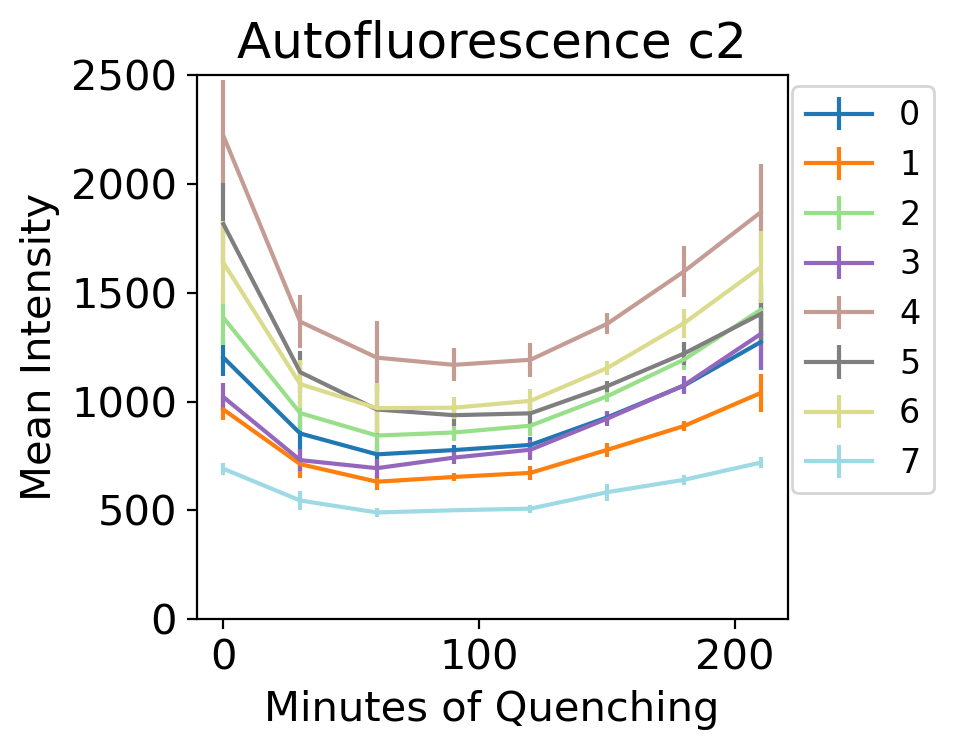

In [179]:
# plot clusters
matplotlib.rcParams.update({'font.size': 15})
if s_slide == '4165NPanc':
    d_color = {'nuc':'Nuclei','cyt':'Cytoplasm'}
    ls_drop = [8,9,10]
    ls_labels = ['0','15','30','45','60']
    for s_loc in sorted(d_color.keys()):
        s_nloc = sorted(set(d_color.keys()) - {s_loc})[0]
        df = df_cluster.loc[:,~df_cluster.columns.str.contains(s_nloc)]
        df_std = df.groupby(['leiden','tissue']).mean().drop(ls_drop)
        df_std = df_std.groupby('leiden').std().T
        fig,ax=plt.subplots(figsize=(14,5),dpi=200)
        df.groupby(['leiden']).mean().drop(ls_drop).T.plot(yerr=df_std,ax=ax,colormap='tab10')
        ax.set_xticks(ax.get_xticks()[1:-1])
        ax.set_xticklabels(ls_labels,rotation=25)
        ax.set_xlabel('Minutes of Quenching')
        ax.set_ylabel('Mean Intensity')
        ax.set_title(f'Autofluorescence in {d_color[s_loc]}',fontsize=18)
        #ax.set_ylim(0,3000)
        ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.05),ncol=2)
        plt.tight_layout()
    fig.savefig(f'{codedir}/Figures/Leiden_{s_slide}_{s_loc}_quenching.png')
elif s_slide=='HER2A':
    if s_sample == 'HER2A_c3_nuclei':
        ls_drop = [8,9,10,11]
    elif s_sample == 'HER2A_c2_nuclei':   
        ls_drop = [8,9]
    ylim = 0,2500
    ncol=1
    figsize = (5,4)
    ls_scene = ['scene006','scene004','scene005','scene009']
    df_cluster = df_cluster[df_cluster.scene.isin(ls_scene)]
    #ls_labels = ['0','30','60','90','120','150'] #,'180'
if s_slide == '808L2':
    if s_sample == '808L2_c2_nuclei':
        ls_drop = [18,19]
        ylim = 0,10000
    elif s_sample == '808L2_c3_nuclei':
        ls_drop = [15,16,17,18,20]
    ncol = 2
    figsize = (6,4)
ls_order = df_cluster.columns[df_cluster.dtypes=='float64'].sort_values()
df = df_cluster.drop('scene',axis=1)
df_std = df.groupby(['leiden','tissue']).mean().drop(ls_drop)
df_std = df_std.groupby('leiden').std().T
fig,ax=plt.subplots(figsize=figsize,dpi=200)
df.groupby(['leiden']).mean().drop(ls_drop).T.loc[ls_order].plot(yerr=df_std.loc[ls_order],ax=ax,colormap='tab20')
ax.set_xlabel('Minutes of Quenching')
ax.set_ylabel('Mean Intensity')
ax.set_title(f'Autofluorescence {s_sample.split("_")[1]}',fontsize=18)
ax.set_ylim(ylim)
ax.legend(loc='upper left', bbox_to_anchor=(.98, 1.01),ncol=ncol,fontsize=12) #
plt.tight_layout()
fig.savefig(f'{codedir}/Figures/Leiden_{s_sample}__quenching.png')

In [180]:
df.loc[:,df.dtypes=='float64'].mean().sort_values()

60      828.059573
90      839.237604
120     863.130667
30      931.321360
150     996.050852
180    1154.349276
210    1364.220069
0      1378.222031
dtype: float64

0.6288070258604277


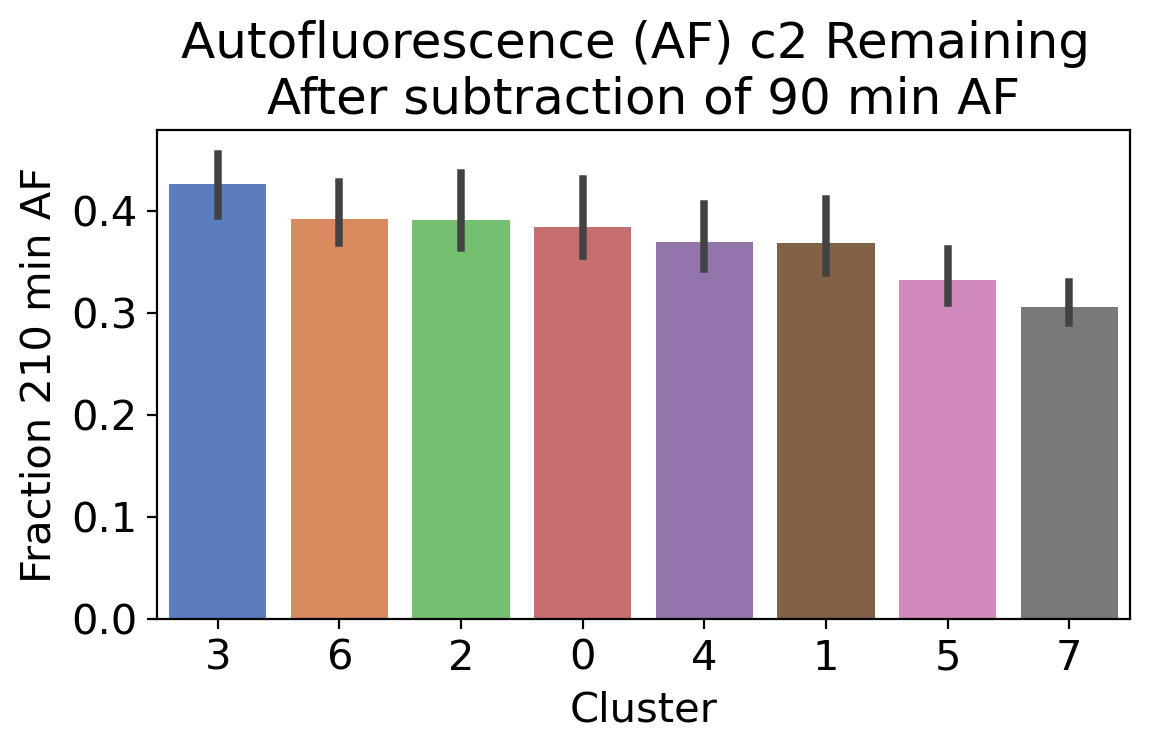

In [181]:
#120 minutes is lowest AF, 270 minutes is highest, 240 near 270, #180 is R5Q; in c3 240 is higher
if s_slide == '808L2':
    i_low = 120
    i_high = 240
if s_slide == 'HER2A':
    i_low = 90
    i_high = 210
matplotlib.rcParams.update({'font.size': 15})
df_m =  df.groupby(['leiden','tissue']).mean().drop(ls_drop)
df_diff = pd.DataFrame()
ls_lei= sorted(set(df.leiden.unique()) - set(ls_drop))#[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
df.loc[:,df.dtypes=='float64'].mean().sort_values()
for i_lei in ls_lei: 
    se_diff = (df_m.loc[i_lei,i_high] - df_m.loc[i_lei,i_low])/df_m.loc[i_lei,i_high]
    se_diff.name= i_lei
    df_diff = df_diff.append(se_diff)
ls_order = df_diff.T.mean().sort_values(ascending=False).index.tolist()
fig, ax = plt.subplots(figsize=(6,4),dpi=200)
sns.barplot(data=df_diff.T,order=ls_order,ax=ax,palette='muted')
ax.set_title(f'Autofluorescence (AF) {s_sample.split("_")[1]} Remaining \nAfter subtraction of {i_low} min AF')
ax.set_ylabel(f'Fraction {i_high} min AF')
ax.set_xlabel('Cluster')
plt.tight_layout()
print(1 - df_diff.mean().mean())
fig.savefig(f'./Figures/Optimal_subtraction_{s_sample}.png')

## compare leiden to annotation

808L2 has biomax annotation info

In [135]:
#load annotation
df_a = pd.read_csv(f'{codedir}/Data/FDA808l-2 specs.csv')
#grade
df_a['Grade'] = df_a.Grade.replace('-',np.nan)
#stage
d_replace = {'-':np.nan, 'IA':'I', 'III':"III", 'IIA':"II", 'IIB':'II', 'IIIA':"III", 'IB':"I",
       ' IIB G2':"II", 'IIIB':"III", 'IVB':'IV', 'IIA G3':"II", 'IIB G3 ':"II", 'IIB G2':"II"}
df_a['Stage'] = df_a.Stage.replace(d_replace)
df_a.loc[:,'Pathology'] = df_a.loc[:,'Pathology diagnosis']
df_a.loc[:,'Age_Q'] = pd.qcut(df_a.Age,4,labels=["Q1", "Q2", "Q3","Q4"])
# add scene
#adata.obs['scene'] = [item.split('_')[1] for item in adata.obs.index]

Pathology
Pathology 0.0


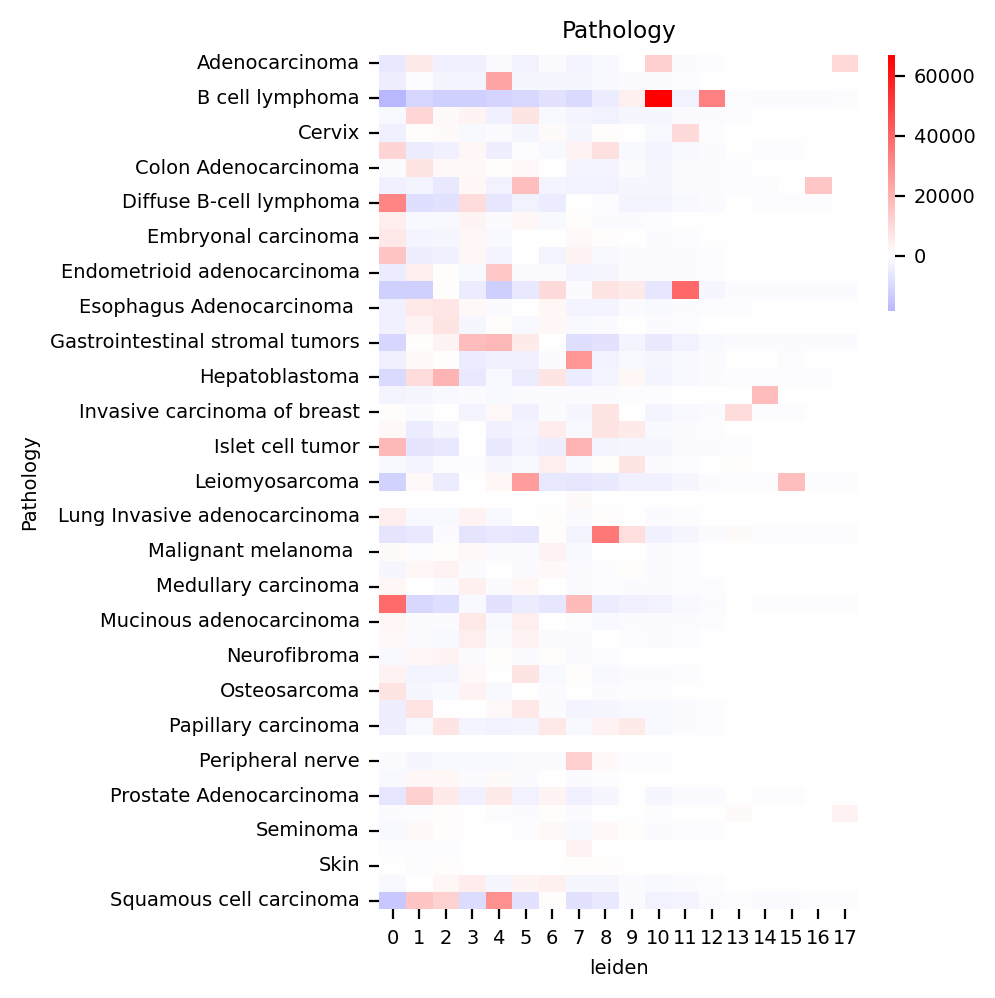

In [142]:
#chi squared and post hoc
matplotlib.rcParams.update({'font.size': 7})
#ls drop from above
ls_index = df_cluster[~df_cluster.leiden.isin(ls_drop)].index
ls_type = [#'Sex',
           #'Organ',
    #'Grade',
    #'Stage',
    #'Type',
    #'Tissue ID.',
    'Pathology',
    'Age_Q']
for s_type in ls_type:
    print(s_type)
    df_cluster[s_type] = df_cluster.scene.map(dict(zip(df_a.Scene,df_a.loc[:,s_type])))
    confusion_matrix = pd.crosstab(df_cluster.loc[ls_index,'leiden'], df_cluster.loc[ls_index,s_type])
    chi2, p, dof, exp = stats.chi2_contingency(confusion_matrix)
    if p < 0.05:
        print(f'{s_type} {p}')
        #post hoc analysis
        observed_vals = confusion_matrix
        expected_vals = pd.DataFrame(exp,index=confusion_matrix.index,columns=confusion_matrix.columns)
        col_sum = observed_vals.sum(axis=1)
        row_sum = observed_vals.sum(axis=0)
        leiden = list(confusion_matrix.index)
        # Find all the unique attitudes towards flying for pairwise comparison
        status = list(confusion_matrix.columns)
        # Iterate through all combinations of parties and status
        diff_vals = confusion_matrix - expected_vals
        #annotated with pval
        '''
        annot_vals = diff_vals.copy()
        print(0.05/diff_vals.size)
        for p in leiden:
            for s in status:
                observed = float(observed_vals.loc[p,s])
                expected = float(expected_vals.loc[p,s])
                col_total = float(col_sum[p])
                row_total = float(row_sum[s])
                expected_row_prop = expected/row_total
                expected_col_prop = expected/col_total
                std_resid = (observed - expected) / (math.sqrt(expected * (1-expected_row_prop) * (1-expected_col_prop)))
                p_val = norm.sf(abs(std_resid))        
                if p_val < 0.05/diff_vals.size:
                    annot_vals.loc[p, s] =  "*"
                else:
                    annot_vals.loc[p, s] =  ""
        #plot
        annot_kws={'fontsize':7, 
           'fontstyle':'italic',  
           'color':"k",
           'alpha':0.6, 
        }
        fig, ax = plt.subplots(figsize = (8,5),dpi=200)
        sns.heatmap(diff_vals,ax=ax,annot=annot_vals,fmt='s',annot_kws=annot_kws,cmap='bwr',center=0)
        '''
        cbar_kws = {'shrink':.3,'aspect':40,'anchor':(0.0, 1)}
        fig, ax = plt.subplots(figsize = (5,5),dpi=200)
        sns.heatmap(diff_vals.T,ax=ax,cmap='bwr',center=0,cbar_kws=cbar_kws)
        ax.set_title(s_type)
        plt.tight_layout()
        fig.savefig(f'./Figures/confusion_matrix_difference_{s_sample}_{s_type}.png')
    break

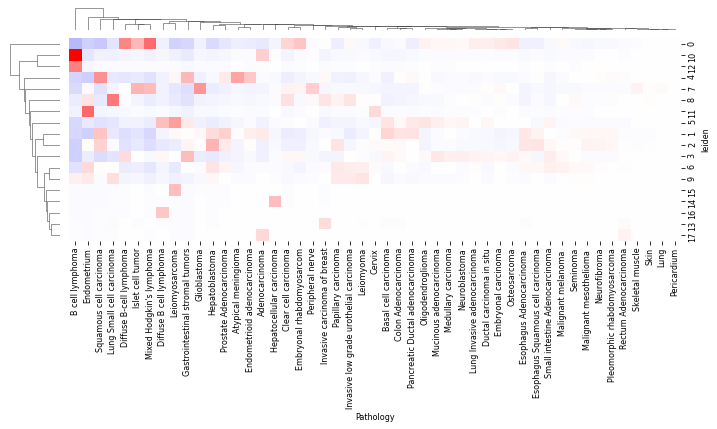

In [150]:
if s_type == 'Organ':
    matplotlib.rcParams.update({'font.size': 8})
    #clustermap
    fig = sns.clustermap(diff_vals.T,center=0,cmap='bwr',figsize = (5,6),  dendrogram_ratio=(.15, .08),
               cbar_pos=None,#(0, .2, .03, .4)
                        )
    plt.tight_layout()
    fig.savefig(f'./Figures/confusion_matrix_difference_{s_sample}_{s_type}_clustermap.png')
if s_type == 'Pathology':
    matplotlib.rcParams.update({'font.size': 8})
    #clustermap
    fig = sns.clustermap(diff_vals,center=0,cmap='bwr',figsize = (10,6),  dendrogram_ratio=(.08, .1),
               cbar_pos=None,#(0, .2, .03, .4)
                        )
    plt.tight_layout()
    fig.savefig(f'./Figures/confusion_matrix_difference_{s_sample}_{s_type}_clustermap.png')

# Compare Percent H2O2 

In [ ]:
#import intensity measurement and exposure time data
ls_sample = ['4165NPanc','B1640','NPPan4165']
df_data = pd.DataFrame()
df_exp = pd.DataFrame()
for s_sample in ls_sample:
    print(s_sample)
    df = pd.read_csv(f'{codedir}/Metadata/{s_sample}/{s_sample}_MeanIntensityMeasurement.csv',index_col=0)
    df_data = df_data.append(df)
    for s_tissue in df[df.tissue.str.contains(s_sample)].tissue:
        df_exp_tissue = pd.read_csv(f'{codedir}/Metadata/{s_sample}/{s_tissue}_ExposureTimes.csv',index_col=0)
        df_exp = df_exp.append(df_exp_tissue, sort='True')


In [ ]:
#add experimental condition annotation
d_condition = {'4165NPanc-73-Scene-001':'3%, 15min_stain',
 '4165NPanc-74-Scene-001':'3%, 15min_blank',
 '4165NPanc-75-Scene-001':'4.5%, 15min_stain',
 '4165NPanc-76-Scene-001':'4.5%, 15min_blank',
 '4165NPanc-77-Scene-001':'6%, 15min_stain',
 '4165NPanc-78-Scene-001':'6%, 15min_blank',
 'B1640-T8-3-Scene-001':'3%, 30min_blank',
 'B1640-T8-4-Scene-001':'3%, 60min_stain',
 'B1640-T8-5-Scene-001':'3%, 30min_stain',
 'B1640-T8-6-Scene-001':'3%, 30min+light_stain',
 'NPPan4165-65-Scene-1': '3%, 30min+light_blank',
 'NPPan4165-66-Scene-1': 'no-quench_blank',
              }
#add annotation
for key, item in d_condition.items():
    s_tissue = key.split('-Scene')[0]
    s_type = item.split('_')[1]
    s_cond = item.split('_')[0]
    s_index = (df_data[df_data.scene==key]).index
    df_data.loc[s_index,'condition'] = s_cond
    df_data.loc[s_index,'slidetype'] = s_type
    df_data.loc[s_index,'cond_type'] = item
#normalize to 50 ms exposure time
df_data['norm_result'] = (df_data.result/df_data.exposure)*50
df_data = df_data.drop_duplicates(keep='first')
d_color = {'c2':'AF488','c3':'AF555',
           #'c4':'AF647','c5':'AF750'
          }

### Summary Plots

In [ ]:
for s_color, s_fluor in d_color.items():
    fig,ax = plt.subplots(figsize=(5,3.5),dpi=200)
    df_1 = df_data[(df_data.color==s_color) & (df_data.rounds=='R1') & (df_data.slidetype=='stain')].loc[:,['condition','norm_result']].set_index('condition')
    df_2 = df_data[(df_data.color==s_color) & (df_data.rounds=='R2') & (df_data.slidetype=='stain')].loc[:,['condition','norm_result']].set_index('condition')
    df_mean = df_data[(df_data.color==s_color) & (df_data.rounds!='R1') & (df_data.slidetype=='blank')].groupby('condition').mean().loc[:,'norm_result']
    df_blank = (pd.DataFrame(df_mean)/df_1)
    df_plot = (df_2/df_1).sort_values('norm_result',ascending=False)
    #plot
    df_plot.plot(legend=False,ax=ax)
    if s_color == 'c2' or s_color == 'c3':
        df_plot_b = df_blank.loc[df_blank.index.isin(df_plot.index)].fillna(df_blank.loc['3%, 30min','norm_result']).loc[df_plot.index]
    else: 
        df_plot_b = df_blank.loc[df_blank.index.isin(df_plot.index)].loc[df_plot.index]
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    ax.set_ylabel('Signal Remaining')
    ax.set_xlabel('H2O2 percent, time')
    ax.set_title(f'{s_fluor} Signal Removal')
    ax.set_ylim(0,1)
    plt.tight_layout()
    fig.savefig(f'./Figures/Quenching_Optimization_{s_color}.png')
    df_plot_b.plot(label='blank',ax=ax,linestyle='--')
    ax.legend(['stain','blank'])
    for tick in ax.get_xticklabels():
        tick.set_rotation(35)
    fig.savefig(f'./Figures/Quenching_Optimization_{s_color}_plusAF.png')
 
    #over af
    fig,ax = plt.subplots(figsize=(5,3.5),dpi=200)
    df_plot_both = (df_plot - df_plot_b).sort_values('norm_result',ascending=False)
    df_plot_both.plot(ax=ax,legend=False)
    for tick in ax.get_xticklabels():
        tick.set_rotation(35)
    ax.set_ylabel('Fraction Signal \n Above Autoflourescence',fontsize=10)
    ax.set_xlabel('H2O2 percent, time')
    ax.set_title(f'{s_fluor} Signal Removal')
    ax.set_ylim(-.1,.3)
    plt.tight_layout()
    fig.savefig(f'./Figures/Quenching_Optimization_{s_color}_aboveAF.png')
    #break

### Single Slide plots

In [ ]:
d_tissue = {'4165NPanc':'Time'}
d_color = {'c2':'AF488','c3':'AF555','c4':'AF647','c5':'AF750'}
for s_tissue, s_test in d_tissue.items():
    df_data_tissue = df_data[(df_data.tissue.str.find(s_tissue)==0) & (df_data.color!='c1')]
    ls_color = sorted(set(df_data_tissue.color))
    ls_cond = sorted(set(df_data_tissue.condition))
    for s_cond in ls_cond:
        fig,ax = plt.subplots(2,2, figsize=(7,5),squeeze=False,dpi=200)
        ax=ax.ravel()
        for idx,s_color in enumerate(ls_color):
            ls_legend=[]
            ls_tissue = sorted(set(df_data_tissue.tissue))
            df_tissue_cond = df_data[(df_data.color==s_color)& (df_data.condition==s_cond)]
            for s_type in ['stain','blank']:
                df_tissue = df_tissue_cond[df_tissue_cond.slidetype==s_type]
                df_tissue = df_tissue.sort_values('round_int')
                s_label = sorted(set(df_tissue.loc[:,'cond_type']))[0]
                df_tissue.norm_result.plot(ax=ax[idx])
                ls_legend= ls_legend + [s_label]
            ax[idx].set_title(d_color[s_color])
            ax[idx].set_ylabel('Mean Intensity')
            ax[idx].set_xlabel('Minutes of Quenching ')
            ax[idx].set_xticks(list(df_tissue.round_int - 1))
            ax[idx].set_xticklabels(list(((df_tissue.round_int - 1).astype(int)*15).astype(str)))
            ax[idx].legend([item.replace('_',' ') for item in ls_legend],fontsize=10)
        plt.tight_layout()
        fig.savefig(f'{codedir}/Figures/vertical_{s_tissue}{s_cond}_quenching.png')

In [ ]:
#fraction quenched
d_rename = {'CK7':'CK7-AF488','CoxIV':'CoxIV-AF555','LaminB1':'LamB1-AF647','Ecad':'Ecad-AF750'}
for s_marker in ['CK7','CoxIV','LaminB1','Ecad']:
    df_change = pd.DataFrame()
    df_data[df_data.marker==s_marker]
    for s_cond in ['3%','4.5%','6%']:
        df = df_data[(df_data.marker==s_marker) & (df_data.condition==s_cond)]
        df_change.loc[s_cond,'first'] = (df[df.rounds=='R1'].result[0] - df[df.rounds=='R2'].result[0])/(df[df.rounds=='R1'].result[0] - df[df.rounds=='R5'].result[0])
        df_change.loc[s_cond,'second'] = (df[df.rounds=='R1'].result[0] - df[df.rounds=='R3'].result[0])/(df[df.rounds=='R1'].result[0] - df[df.rounds=='R5'].result[0])
        df_change.loc[s_cond,'third'] = (df[df.rounds=='R1'].result[0] - df[df.rounds=='R4'].result[0])/(df[df.rounds=='R1'].result[0] - df[df.rounds=='R5'].result[0])
    fig, ax = plt.subplots(figsize=(3.4,3),dpi=200)
    df_change.plot(kind='bar',ax=ax,alpha=.8)
    ax.legend(loc='lower right',title='quench no.',fontsize=10,title_fontsize=10)
    ax.set_title(f'{d_rename[s_marker]}')
    ax.set_ylabel('Fraction of Signal\n Quenched')
    ax.set_xlabel('H2O2 percentage')
    plt.tight_layout()
    fig.savefig(f'{codedir}/Figures/quenching_rate_by_H2O2_{s_marker}.png')

In [ ]:
df_quen = pd.DataFrame()
#how much does AF reduce in 1st quench?
for s_color in ['c2','c3','c4','c5']:
    df_test = df_data[(df_data.slidetype=='blank') & (df_data.color==s_color) &(df_data.scene.str.contains('4165NPanc-')) & (df_data.rounds.isin(['R1','R2']))]
    i_result = df_test.groupby('rounds').mean().result.loc['R2']/df_test.groupby('rounds').mean().result.loc['R1']
    print(f'{s_color}: {1-i_result}')
    ls_single = []
    for s_tissue in ['4165NPanc-74', '4165NPanc-76', '4165NPanc-78']:
        i_single = df_test[(df_test.tissue==s_tissue) & (df_test.rounds=='R2')].result[0]/(df_test[(df_test.tissue==s_tissue) & (df_test.rounds=='R1')].result[0])
        ls_single.append(i_single)
        df_quen.loc[f'{s_tissue}_{s_color}','result'] = 1 - i_single
        df_quen.loc[f'{s_tissue}_{s_color}','channel'] = s_color
    print(np.std(ls_single))

In [ ]:
fig, ax = plt.subplots(figsize= (3.2,3),dpi=200)
sns.barplot(data=df_quen, x='channel', y='result', palette = 'muted',ci='sd',ax=ax)
sns.stripplot(data=df_quen, x='channel', y='result', palette = 'dark',ax=ax)
ax.set_ylabel('Percent')
ax.set_title('Reduction in\n Autofluorescence')
plt.tight_layout()
fig.savefig(f'{codedir}/Figures/reduction_in_AF_quenching.png')

In [ ]:
#how much does AF reduce in 1st quench?
for s_color in ['c2','c3','c4','c5']:
    df_test = df_data[(df_data.slidetype=='blank') & (df_data.color==s_color) &(df_data.scene.str.contains('4165NPanc-')) & (df_data.rounds.isin(['R1','R2']))]
    i_result = df_test.groupby('rounds').std().result.loc['R2']/df_test.groupby('rounds').std().result.loc['R1']
    print(f'{s_color}: {i_result}')

In [ ]:
# just AF488
d_tissue = {'4165NPanc':'Time'}
d_color = {'c2':'AF488','c3':'AF555','c4':'AF647','c5':'AF750'}
for s_tissue, s_test in d_tissue.items():
    df_data_tissue = df_data[(df_data.tissue.str.find(s_tissue)==0) & (df_data.color!='c1')]
    ls_color = sorted(set(df_data_tissue.color))
    ls_cond = sorted(set(df_data_tissue.condition))
    for s_cond in ls_cond:
        fig,ax = plt.subplots(figsize=(4,3),squeeze=False,dpi=200)
        ax=ax.ravel()
        for idx,s_color in enumerate(ls_color):
            ls_legend=[]
            ls_tissue = sorted(set(df_data_tissue.tissue))
            df_tissue_cond = df_data[(df_data.color==s_color)& (df_data.condition==s_cond)]
            for s_type in ['stain','blank']:
                df_tissue = df_tissue_cond[df_tissue_cond.slidetype==s_type]
                df_tissue = df_tissue.sort_values('round_int')
                s_label = sorted(set(df_tissue.loc[:,'cond_type']))[0]
                df_tissue.norm_result.plot(ax=ax[idx])
                ls_legend= ls_legend + [s_label]
            ax[idx].set_title(d_color[s_color])
            ax[idx].set_ylabel('Mean Intensity')
            ax[idx].set_xlabel('Minutes of Quenching ')
            ax[idx].set_xticks(list(df_tissue.round_int - 1))
            ax[idx].set_xticklabels(list(((df_tissue.round_int - 1).astype(int)*15).astype(str)))
            ax[idx].legend([item.replace('_',' ') for item in ls_legend],fontsize=12)
            break
        plt.tight_layout()
        fig.savefig(f'{codedir}/Figures/{s_tissue}/AF488_{s_tissue}{s_cond}_quenching.png')

# Compare Time and Addition of Incandescent Light

In [ ]:
d_tissue = {'B1640':'Light'}
d_color = {'c2':'AF488','c3':'AF555','c4':'AF647','c5':'AF750'}
for s_tissue, s_test in d_tissue.items():
    df_data_tissue = df_data[(df_data.tissue.str.contains(s_tissue)) & (df_data.color!='c1')]
    ls_color = sorted(set(df_data_tissue.color))
    ls_cond = ['30min', '60min', '30min+light']
    for s_color in ls_color:
        fig,ax = plt.subplots(2,2, figsize=(7,5),squeeze=False,dpi=200)
        ax=ax.ravel()
        for idx,s_cond in enumerate(ls_cond):
            ls_legend=[]
            ls_tissue = sorted(set(df_data_tissue.tissue))
            df_tissue_cond = df_data[(df_data.color==s_color)& (df_data.condition==s_cond)]
            for s_type in ['stain','blank']:
                if s_type == 'blank':
                    df_tissue = df_data[(df_data.cond_type=='30min_blank') & (df_data.color==s_color)]
                else:
                    df_tissue = df_tissue_cond[df_tissue_cond.slidetype==s_type]
                df_tissue = df_tissue.sort_values('round_int')
                s_label = sorted(set(df_tissue.loc[:,'cond_type']))[0]
                df_tissue.norm_result.plot(ax=ax[idx])
                ls_legend= ls_legend + [s_label]
            ax[idx].set_title(d_color[s_color])
            ax[idx].set_ylabel('Mean Intensity')
            ax[idx].set_xlabel('Minutes of Quenching')
            ax[idx].set_xticks(list(df_tissue.round_int - 1))
            fontdict = {'fontsize': 10}
            ax[idx].set_xticklabels(list(((df_tissue.round_int - 1).astype(int)*30).astype(str)),fontdict=fontdict)
            if idx==1:
                ax[idx].set_xticklabels(list(((df_tissue.round_int - 1).astype(int)*60).astype(str)),fontdict=fontdict)
            ax[idx].legend([item.replace('_',' ') for item in ls_legend],fontsize=10)
        plt.tight_layout()
        fig.savefig(f'{codedir}/Figures/{s_tissue}/vertical_{s_tissue}{s_color}_quenching.png')

In [ ]:
#just AF488
d_tissue = {'B1640':'Light'}
d_color = {'c2':'AF488','c3':'AF555','c4':'AF647','c5':'AF750'}
for s_tissue, s_test in d_tissue.items():
    df_data_tissue = df_data[(df_data.tissue.str.contains(s_tissue)) & (df_data.color!='c1')]
    ls_color = sorted(set(df_data_tissue.color))
    ls_cond = ['30min', '60min', '30min+light']
    for s_cond in ls_cond:
        fig,ax = plt.subplots(figsize=(4,3),squeeze=False,dpi=200)
        ax=ax.ravel()
        for idx,s_color in enumerate(ls_color):
            ls_legend=[]
            ls_tissue = sorted(set(df_data_tissue.tissue))
            df_tissue_cond = df_data[(df_data.color==s_color)& (df_data.condition==s_cond)]
            for s_type in ['stain','blank']:
                if s_type == 'blank':
                    df_tissue = df_data[(df_data.cond_type=='30min_blank') & (df_data.color==s_color)]
                else:
                    df_tissue = df_tissue_cond[df_tissue_cond.slidetype==s_type]
                df_tissue = df_tissue.sort_values('round_int')
                s_label = sorted(set(df_tissue.loc[:,'cond_type']))[0]
                df_tissue.norm_result.plot(ax=ax[idx])
                ls_legend= ls_legend + [s_label]
            ax[idx].set_title(d_color[s_color])
            ax[idx].set_ylabel('Mean Intensity')
            ax[idx].set_xlabel('Minutes of Quenching')
            ax[idx].set_xticks(list(df_tissue.round_int - 1))
            fontdict = {'fontsize': 10}
            ax[idx].set_xticklabels(list(((df_tissue.round_int - 1).astype(int)*30).astype(str)),fontdict=fontdict)
            if idx==1:
                ax[idx].set_xticklabels(list(((df_tissue.round_int - 1).astype(int)*60).astype(str)),fontdict=fontdict)
            ax[idx].legend([item.replace('_',' ') for item in ls_legend],fontsize=12)
            break
        plt.tight_layout()
        fig.savefig(f'{codedir}/Figures/{s_tissue}/AF488_{s_tissue}{s_color}{s_cond}_quenching.png')

# Compare Blank Slide Quenched and Imaged vs. Imaged Only

Does the reducion in autofluorescnce come from the quenching or imaging process (i.e. is it chemical or photo bleaching of autofluorescnce) 

In [ ]:
d_tissue = {'NPPan4165':'No Quench Ctrl'}
d_color = {'c2':'AF488','c3':'AF555','c4':'AF647','c5':'AF750'}
d_label = {'no-quench_blank':'imaging only','30min+light_blank':'quench + image'}
for s_tissue, s_test in d_tissue.items():
    df_data_tissue = df_data[(df_data.tissue.str.contains(s_tissue)) & (df_data.color!='c1')]
    ls_color = sorted(set(df_data_tissue.color))
    fig,ax = plt.subplots(2,2, figsize=(7,5.5),squeeze=False,dpi=200)
    ax=ax.ravel()
    for idx,s_color in enumerate(ls_color):
        ls_legend=[]
        ls_tissue = sorted(set(df_data_tissue.tissue))
        for s_tissue in ls_tissue:
            df_tissue = df_data[(df_data.tissue==s_tissue) & (df_data.color==s_color)]
            df_tissue = df_tissue.sort_values('round_int')
            s_label = d_label[sorted(set(df_tissue.loc[:,'cond_type']))[0]]
            df_tissue.norm_result.plot(ax=ax[idx])
            ls_legend= ls_legend + [s_label]
        ax[idx].set_title(d_color[s_color])
        ax[idx].set_ylabel('Mean Intensity')
        ax[idx].set_xlabel('Minutes of Quenching')
        ax[idx].set_xticks(list(df_tissue.round_int - 1))
        ax[idx].set_xticklabels(list(((df_tissue.round_int - 1)*30).astype(int).astype(str)))
        ax[idx].legend([item.replace('_',' ') for item in ls_legend],fontsize=8)
        ax[idx].set_xlim(left=0)
    plt.tight_layout()
    fig.savefig(f'{codedir}/Figures/NPPan4165/vertical_{s_tissue}_imagingonly.png')

In [ ]:
#just AF488
d_tissue = {'NPPan4165':'No Quench Ctrl'}
d_color = {'c2':'AF488','c3':'AF555','c4':'AF647','c5':'AF750'}
d_label = {'no-quench_blank':'imaging only','30min+light_blank':'quench + image'}
for s_tissue, s_test in d_tissue.items():
    df_data_tissue = df_data[(df_data.tissue.str.contains(s_tissue)) & (df_data.color!='c1')]
    ls_color = sorted(set(df_data_tissue.color))
    fig,ax = plt.subplots(figsize=(4,3),squeeze=False,dpi=200)
    ax=ax.ravel()
    for idx,s_color in enumerate(ls_color):
        ls_legend=[]
        ls_tissue = sorted(set(df_data_tissue.tissue))
        for s_tissue in ls_tissue:
            df_tissue = df_data[(df_data.tissue==s_tissue) & (df_data.color==s_color)]
            df_tissue = df_tissue.sort_values('round_int')
            s_label = d_label[sorted(set(df_tissue.loc[:,'cond_type']))[0]]
            df_tissue.norm_result.plot(ax=ax[idx])
            ls_legend= ls_legend + [s_label]
        ax[idx].set_title(d_color[s_color])
        ax[idx].set_ylabel('Mean Intensity')
        ax[idx].set_xlabel('Minutes of Quenching')
        ax[idx].set_xticks(list(df_tissue.round_int - 1))
        ax[idx].set_xticklabels(list(((df_tissue.round_int - 1)*30).astype(int).astype(str)))
        ax[idx].legend([item.replace('_',' ') for item in ls_legend],fontsize=12)
        ax[idx].set_xlim(left=0)
        break
    plt.tight_layout()
    fig.savefig(f'{codedir}/Figures/NPPan4165/AF488_{s_tissue}_imagingonly.png')

# Temperature of Buffer under Various Conditions

Our intepretation is that the heat comes from the light, but also from the exotermic reaction of H2O2 oxidation.

In [14]:
df_temp = pd.read_csv(f'{codedir}/Data/TemperatureExperiments.csv',index_col = 0)

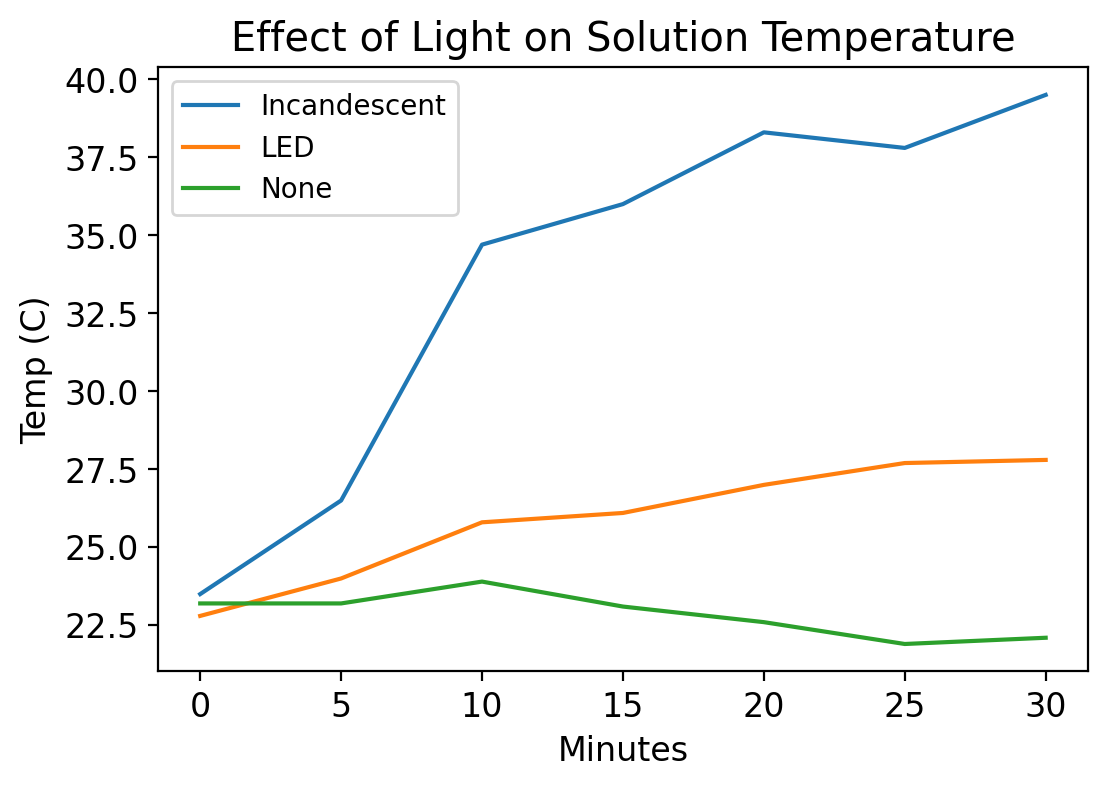

In [17]:
matplotlib.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(dpi=200)
df_temp.iloc[:7,[0,2,4]].plot(kind='line', ax=ax)
ax.set_ylabel('Temp (C)')
ax.set_xlabel('Minutes')
ax.legend(labels = [item.split('_')[0] for item in ax.get_legend_handles_labels()[1]],fontsize=10)
ax.set_title('Effect of Light on Solution Temperature')
fig.savefig(f'{codedir}/Figures/EffectofLightonQuenchTemperature.png')

In [ ]:
df_temp.iloc[:7,:]

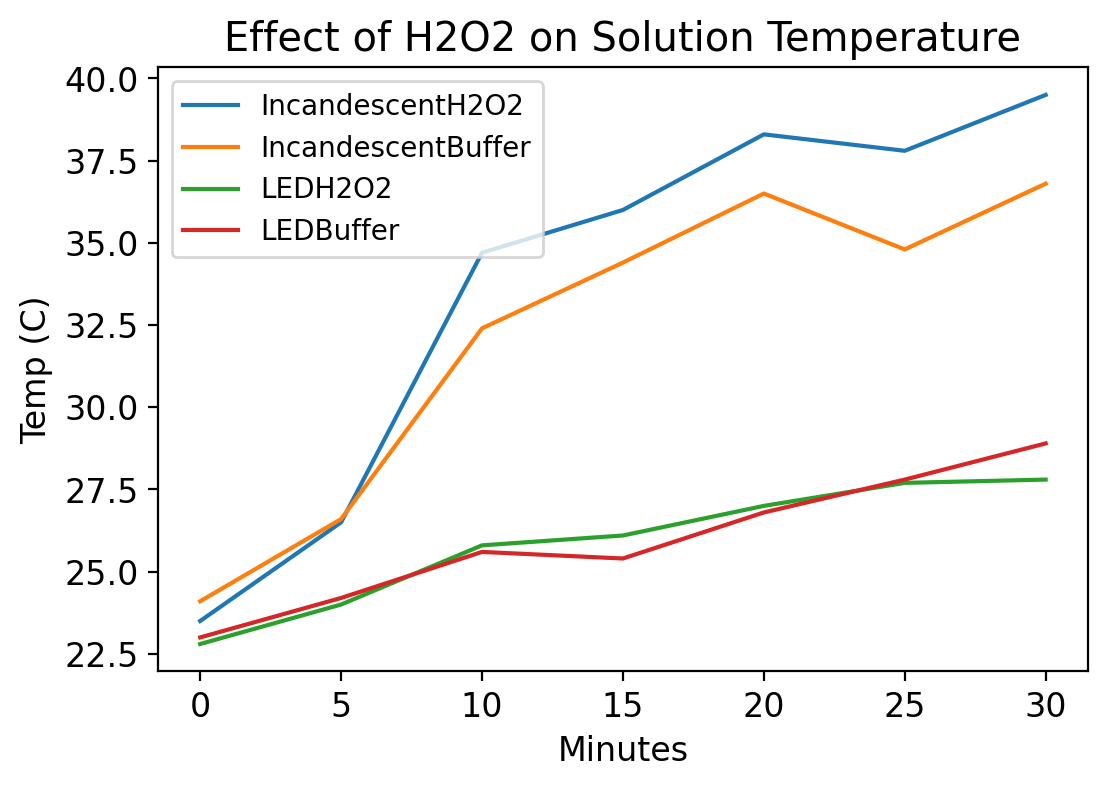

In [18]:
matplotlib.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(dpi=200)
df_temp.iloc[:7,[0,1,2,3]].plot(kind='line', ax=ax)
ax.set_ylabel('Temp (C)')
ax.set_xlabel('Minutes')
ax.legend(labels = [item.split('_')[0] + item.split('_')[2] for item in ax.get_legend_handles_labels()[1]],fontsize=10)
ax.set_title('Effect of H2O2 on Solution Temperature')
fig.savefig(f'{codedir}/Figures/EffectofH2O2onQuenchTemperature.png')

# Temperature result interpretation

The incandescent light physically heats the solution, but also increases the rate of H2O2 oxidation and exothermic heat production. This effect is not seen with LED light.

We also observed the most bubbles in the Incandescent/H2O2 solution, suggesting the highest level of oxidation.